# Evaluate Head Localization

A script for evaluating the performance of a head localization system against ground truth head bounding box coordinates annotated by hand using [VIA](https://www.robots.ox.ac.uk/~vgg/software/via/).

Takes in pickled dictionaries of ground truth head bounding box coordinates and head bounding box coordinates generated by the system being evaluated.

The ground truth dictionary has key of frame filename, and value of (x, y, w, h) tuple of the annotated head bounding box in the frame. The system-generated head bounding box coordinates has key of frame number and value of list of (x, y, w, h) tuples of the detected heads in the frame.

Compares the two dictionaries using [intersection over union](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) as a metric for evaluating our head localization system's performance. Intersection over union (IoU) measures the amount of overlap between the bounding boxes from our system and from our ground truth hand annotations.

In [1]:
import os
import pickle

import cv2

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 12] # matplotlib setting to control the size of display images

In [3]:
def load_pickled_labels_into_dict(label_dicts_dir_path, filename_part_to_drop):
    """
    Loads pickled frame-to-feature dictionaries for multiple clips into a single nested dictionary for all clips.
    
    Parameters:
    - label_dicts_dir_path: the path to the folder containing the pickled frame-to-feature dictionaries (of all the clips) for this feature.
    - filename_part_to_drop: the part of the pickled frame-to-feature dictionary filenames we should drop (for determining clip name keys for the single nested dictionary).
    
    Returns a nested dictionary where keys are clip names, and values are dictionaries mapping frame number keys to feature label values (0 if feature is not in the frame; 1 if it is).
    """
    # Get list of all files and directories in the directory with all the pickled frame-to-feature dictionaries for all the clips
    file_list = os.listdir(label_dicts_dir_path)

    # Create dictionary where keys are clip names, values are dictionaries of the frame-to-feature labels
    label_dicts = {}
    # For each pickled dict...
    for filename in file_list:
        # We only want to process our pickled dictionaries, which are pkl files
        if filename.endswith(".pkl"):
            clip = filename.replace(filename_part_to_drop, "")

            # Load (deserialize) pickled data
            with open(label_dicts_dir_path + "/" + filename, "rb") as f:
                label_dicts[clip] = pickle.load(f)
                
    return label_dicts

In [4]:
def evaluate_head_localization_system(system_localization_dicts, ground_truth_dict):
    """
    Evaluates the performance of a system by comparing bounding boxes as generated by the system, versus ground-truth bounding box coordinates.
    
    Parameters:
    - system_localization_dicts: assigned by our system. a dictionary from clip name keys to values of dictionaries of frame number keys to list of bounding box (x, y, w, h) tuples.
    - ground_truth_dict: a dictionary from frame filename to (x, y, w, h) ground-truth bounding box tuple hand-annotated using VIA.
    
    Returns mean intersection over union (IoU) score for all the frames in the ground_truth_dict, as a measure of head localization performance.
    Also returns the number of the ground truth frames that had a head detected by the system,
    and the mean IoU score for all the ground_truth_dict frames with head detected by the system.
    """
    iou_sum = 0     # for summing up all the iou scores for all the frames in the ground_truth_dict
    num_frames = 0
    num_frames_with_head_detected = 0
    for frame_filename in ground_truth_dict:
        frame_num_and_extension = frame_filename.split("_")[-1]
        clip_name = frame_filename.replace("_" + frame_num_and_extension, "")
        frame_num = int(frame_num_and_extension.split(".")[0])
        
        # If system detected multiple heads in a frame, take the maximum IoU score as the IoU score for the frame
        iou = 0 # assume IoU score of 0 for now
        detected_heads = head_localization_dicts[clip_name][frame_num]
        if len(detected_heads) > 0:
            print("detected head in", frame_filename)
            num_frames_with_head_detected += 1
        for detected_head in detected_heads:
            iou = max(iou, calculate_intersection_over_union(detected_head, ground_truth_dict[frame_filename]))
        
        iou_sum += iou
        num_frames += 1

    # Calculate mean IoU score for all the frames in the ground_truth_dict
    mean_iou_score_for_all_frames = iou_sum / num_frames
    
    # Calculate mean IoU score for just the ground_truth_dict frames with head detected
    mean_iou_score_for_head_detected_frames = iou_sum / num_frames_with_head_detected
    
    return mean_iou_score_for_all_frames, num_frames_with_head_detected, mean_iou_score_for_head_detected_frames

In [5]:
def calculate_intersection_over_union(box_coords_1, box_coords_2):
    """
    Adapted from https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/.
    
    Intersection over Union (IoU) is a common metric for evaluating the performance of object detection.
    IoU is (the area of overlap) / (the area of union) of the system-generated bounding box and the ground truth bounding box.
    
    Parameters:
    - box_coords_1: one set of bounding box coordinates, formatted (x, y, w, h).
    - box_coords_2: the other set of bounding box coordinates, formatted (x, y, w, h).
    
    Returns IoU as computed from the two sets of bounding box coordinates.
    """
    # (x1, y1) is vertex of box 1 at the top left corner
    # (x1 + w1, y1 + h1) is vertex of box 1 at bottom right corner
    x1, y1, w1, h1 = box_coords_1
    x2, y2, w2, h2 = box_coords_2
    
    # Determine the coordinates of the rectangle that forms the intersection of the two bounding boxes.
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    
    # Compute the area of the intersection rectangle.
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # Compute the area of each bounding box rectangle.
    boxAArea = w1 * h1
    boxBArea = w2 * h2
    
    # Compute the intersection over union by taking the intersection area and
    # dividing it by the sum of the bounding box areas - the intersection area
    # (must subtract the intersection area to avoid double counting the intersection area).
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou


In [6]:
def load_rgb_img(img_path):
    """
    Takes in img_path, the file path to an image.
    Reads the image at that path, and returns the RGB image.
    """
    img_raw = cv2.imread(img_path)
    
    # OpenCV imread reads in images in BGR color space, so must convert from BGR to RGB
    img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    
    return img_rgb

In [7]:
def visualize_system_and_ground_truth_head_bounding_boxes(frame_filename, system_localization_dicts, via_filename_to_bounding_box_coords_map):
    """
    Uses matplotlib to display an image with system-detected (in blue) and ground truth head bounding boxes (in yellow) drawn onto the image.
    
    Parameters:
    - frame_filename: the filename of the frame whose head bounding boxes we wish to visualize.
    - system_localization_dicts:  assigned by our system. a dictionary from clip name keys to values of dictionaries of frame number keys to list of bounding box (x, y, w, h) tuples.
    - via_filename_to_bounding_box_coords_map: dictionary mapping key of filename to (x, y, w, h) tuple of the annotated head bounding box in the frame.
    """  
    # Find original image from frames folder
    frame_num_and_extension = frame_filename.split("_")[-1]
    clip_name = frame_filename.replace("_" + frame_num_and_extension, "")
    frame_num = int(frame_num_and_extension.split(".")[0])
    img = load_rgb_img("frames/" + clip_name + "_frames/" + frame_filename)
    
    # Make a copy of original image so original image is retained while we draw bounding boxes on the copy
    img_head_localization = img.copy()
    
    ## Draw system-detected head bounding boxes in blue
    # Find the bounding box coords for this particular frame num
    system_head_bounding_box_coords = system_localization_dicts[clip_name][frame_num]
    # For each system-detected instance of the feature...
    for (x,y,w,h) in system_head_bounding_box_coords:
        # Draw a blue bounding box around the instance of the feature
        img_head_localization = cv2.rectangle(img_head_localization,(x,y),(x+w,y+h),(0,194,255),2)
    
    ## Draw the VIA-hand-annotated head bounding box in yellow
    # Find the annotated bounding box coords for this particular frame
    annotated_head_bounding_box_coords = via_filename_to_bounding_box_coords_map[frame_filename]
    x, y, w, h = annotated_head_bounding_box_coords
    # Convert from floats to ints because cv2.rectangle expects ints
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)
    # Draw a yellow bounding box for the annotated head
    img_head_localization = cv2.rectangle(img_head_localization,(x,y),(x+w,y+h),(247,222,58),2)
    
    # Save visualization of system-detected and ground-truth head bounding boxes
    # OpenCV imwrite expects BGR image, so convert from RGB to BGR color space before using OpenCV's imwrite function to save it
    cv2.imwrite("head_localization_example_evaluation.jpg", cv2.cvtColor(img_head_localization, cv2.COLOR_RGB2BGR))
    
    plt.imshow(img_head_localization)
    plt.show()

## Evaluating Head Localization Using Single Haar Cascade

In [8]:
# Load all head bounding box coordinates predicted by a Haar Cascade head detection system into a single nested dictionary
head_localization_dicts = load_pickled_labels_into_dict("head_localization_dicts_haar", "_frame_to_head_box_coords_dict.pkl")

# Load all ground-truth head bounding box coordinates annotated using VIA into a dictionary
# Load (deserialize) pickled data
with open("frame_to_head_box_annotation.pkl", "rb") as f:
    ground_truth_dict = pickle.load(f)

In [9]:
# Evaluate performance of head localization using Haar Cascades
evaluate_head_localization_system(head_localization_dicts, ground_truth_dict)

detected head in amadeus_00008.jpg
detected head in amadeus_02506.jpg
detected head in argo_03204.jpg
detected head in birdman_05082.jpg
detected head in birdman_05277.jpg
detected head in chicago_03207.jpg
detected head in departed_00001.jpg
detected head in departed_00118.jpg
detected head in departed_00268.jpg
detected head in departed_01577.jpg
detected head in emperor_00005.jpg
detected head in emperor_00175.jpg
detected head in emperor_00677.jpg
detected head in kings_00005.jpg
detected head in no_country_clip2_00561.jpg
detected head in no_country_clip2_00724.jpg
detected head in no_country_clip2_00964.jpg
detected head in shakespeare_clip1_00995.jpg
detected head in shakespeare_clip2_02176.jpg
detected head in shakespeare_clip2_02314.jpg


(0.1411379967746227, 20, 0.529267487904835)

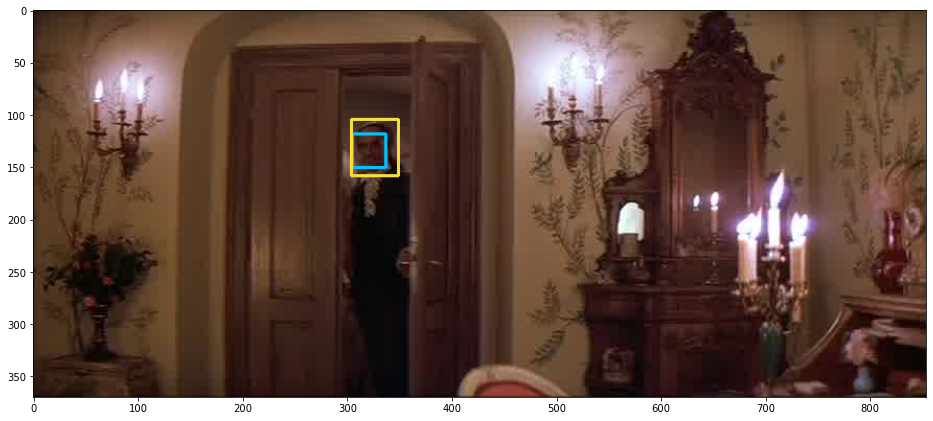

In [10]:
visualize_system_and_ground_truth_head_bounding_boxes("amadeus_00008.jpg", head_localization_dicts, ground_truth_dict)

## Evaluating Head Localization Using Two Haar Cascades

In [11]:
# Load all head bounding box coordinates predicted by a Haar Cascade head detection system into a single nested dictionary
head_localization_dicts = load_pickled_labels_into_dict("head_localization_dicts_haar_multiple_2", "_frame_to_head_box_coords_dict.pkl")

# Load all ground-truth head bounding box coordinates annotated using VIA into a dictionary
# Load (deserialize) pickled data
with open("frame_to_head_box_annotation.pkl", "rb") as f:
    ground_truth_dict = pickle.load(f)

In [12]:
# Evaluate performance of head localization using Haar Cascades
evaluate_head_localization_system(head_localization_dicts, ground_truth_dict)

detected head in amadeus_00008.jpg
detected head in amadeus_02506.jpg
detected head in amadeus_03039.jpg
detected head in argo_03204.jpg
detected head in birdman_05082.jpg
detected head in birdman_05277.jpg
detected head in chicago_03207.jpg
detected head in departed_00001.jpg
detected head in departed_00118.jpg
detected head in departed_00268.jpg
detected head in departed_01577.jpg
detected head in emperor_00005.jpg
detected head in emperor_00175.jpg
detected head in emperor_00677.jpg
detected head in kings_00005.jpg
detected head in kings_00457.jpg
detected head in no_country_clip2_00561.jpg
detected head in no_country_clip2_00724.jpg
detected head in no_country_clip2_00964.jpg
detected head in shakespeare_clip1_00995.jpg
detected head in shakespeare_clip2_02176.jpg
detected head in shakespeare_clip2_02314.jpg


(0.15994199033774237, 22, 0.5452567852423035)

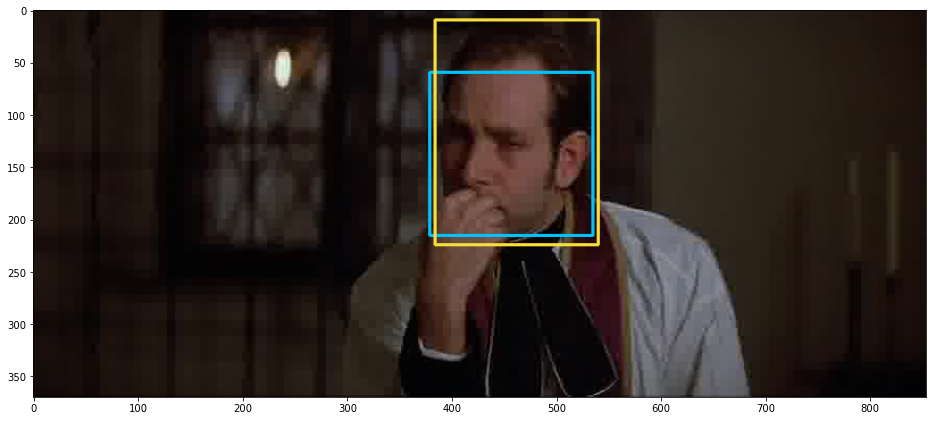

In [13]:
visualize_system_and_ground_truth_head_bounding_boxes("amadeus_03039.jpg", head_localization_dicts, ground_truth_dict)

## Evaluating Head Localization Using Three Haar Cascades

In [14]:
# Load all head bounding box coordinates predicted by a Haar Cascade head detection system into a single nested dictionary
head_localization_dicts = load_pickled_labels_into_dict("head_localization_dicts_haar_multiple_3", "_frame_to_head_box_coords_dict.pkl")

# Load all ground-truth head bounding box coordinates annotated using VIA into a dictionary
# Load (deserialize) pickled data
with open("frame_to_head_box_annotation.pkl", "rb") as f:
    ground_truth_dict = pickle.load(f)

In [15]:
# Evaluate performance of head localization using Haar Cascades
evaluate_head_localization_system(head_localization_dicts, ground_truth_dict)

detected head in amadeus_00008.jpg
detected head in amadeus_02506.jpg
detected head in amadeus_03039.jpg
detected head in argo_03204.jpg
detected head in birdman_05082.jpg
detected head in birdman_05277.jpg
detected head in chicago_03207.jpg
detected head in departed_00001.jpg
detected head in departed_00118.jpg
detected head in departed_00268.jpg
detected head in departed_01577.jpg
detected head in emperor_00005.jpg
detected head in emperor_00175.jpg
detected head in emperor_00677.jpg
detected head in kings_00005.jpg
detected head in kings_00457.jpg
detected head in no_country_clip2_00561.jpg
detected head in no_country_clip2_00724.jpg
detected head in no_country_clip2_00964.jpg
detected head in shakespeare_clip1_00995.jpg
detected head in shakespeare_clip2_02176.jpg
detected head in shakespeare_clip2_02314.jpg


(0.15994199033774237, 22, 0.5452567852423035)

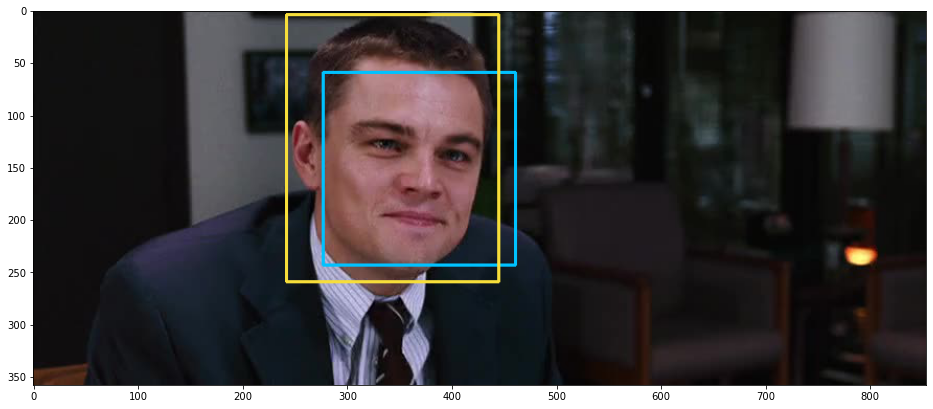

In [16]:
visualize_system_and_ground_truth_head_bounding_boxes("departed_00001.jpg", head_localization_dicts, ground_truth_dict)